# Importing the Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import plotly.graph_objects as go
import umap

In [2]:
from nltk.corpus import stopwords

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initial Preprocessing

In [6]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [8]:
train_texts = [text for text in df_train['comment_text']]
test_texts = [text for text in df_test['comment_text']]

In [9]:
labels_toxic = [val for val in df_train['toxic']]
labels_severe_toxic = [val for val in df_train['severe_toxic']]
labels_obscene = [val for val in df_train['obscene']]
labels_threat = [val for val in df_train['threat']]
labels_insult = [val for val in df_train['insult']]
labels_identity_hate = [val for val in df_train['identity_hate']]

In [10]:
def remove_special_symbols(texts):
    # Defining a regular expression pattern to match special symbols
    special_symbol_pattern = r'[^A-Za-z\s]'  # This pattern matches anything that is not a letter, digit, or whitespace

    # Creating a list to store the filtered texts
    filtered_texts = []

    # Iterating through each text and removing special symbols
    for text in texts:
        filtered_text = re.sub(special_symbol_pattern, '', text)
        filtered_texts.append(filtered_text)

    return filtered_texts

In [11]:
filtered_train_texts = remove_special_symbols(train_texts)
filtered_test_texts = remove_special_symbols(test_texts)

In [12]:
# Choosing max_features value
max_features = 500

# Initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

# Fitting and transforming the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(filtered_train_texts)

# Transforming the test data
X_test_tfidf = tfidf_vectorizer.transform(filtered_test_texts)

In [13]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Utility Functions

In [14]:
def visualize_3d(X, reduction_technique):
  # Creating a 3D scatter plot for the training data
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X[:, 0], X[:, 1], X[:, 2], label='Train Data', marker='o')

  # Adding labels and title
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')
  ax.set_zlabel('Component 3')
  ax.set_title(f'3D {reduction_technique} Visualization of Training Data')
  ax.legend()

  # Showing the plot
  plt.show()

In [15]:
def visualize_3d_labels(X):
  # Creating subplots
  fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, subplot_kw=dict(projection='3d'))

  # Flattening the axes for easy iteration
  axes = axes.flatten()

  # List of label vectors and their names
  label_vectors = [labels_toxic, labels_severe_toxic, labels_obscene, labels_threat, labels_insult, labels_identity_hate]
  label_names = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']

  # Plotting each label in a separate subplot
  for ax, label_vector, label_name in zip(axes, label_vectors, label_names):
      ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=label_vector, cmap='viridis', marker='o')
      ax.set_title(label_name)
      ax.set_xlabel('Component 1')
      ax.set_ylabel('Component 2')
      ax.set_zlabel('Component 3')

  # Adjusting layout
  plt.tight_layout()

  # Showing the plot
  plt.show()

In [16]:
def visualize_3d_interactive(X, labels=None, label_type=None):
  # Creating a 3D scatter plot for the training data
  fig = go.Figure()

  fig.add_trace(go.Scatter3d(
      x=X[:, 0],
      y=X[:, 1],
      z=X[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color='blue' if labels == None else labels,
          colorscale='Viridis',
          opacity=0.7
      ),
      name='Train Data' if label_type == None else label_type
  ))

  # Updating layout for better visibility
  fig.update_layout(
      scene=dict(
          xaxis_title='Component 1',
          yaxis_title='Component 2',
          zaxis_title='Component 3',
          xaxis=dict(backgroundcolor="rgb(200, 200, 230)"),
          yaxis=dict(backgroundcolor="rgb(230, 200,230)"),
          zaxis=dict(backgroundcolor="rgb(230, 230,200)")
      ),
      showlegend=True,
      height=600
  )

  # Showing the plot
  fig.show()

# PCA

To perform PCA, we shall first scale our data.

In [17]:
scaler = StandardScaler()
X_train_dense_scaled = scaler.fit_transform(X_train_dense)
X_test_dense_scaled = scaler.transform(X_test_dense)

In [18]:
# Initializing PCA with the desired number of components
n_components = 3 # 2min10sec for n_components = 500 and max_features=1000
pca = PCA(n_components=n_components)

# Fitting and transforming the training data
X_train_pca = pca.fit_transform(X_train_dense_scaled)

# Transforming the test data
X_test_pca = pca.transform(X_test_dense)

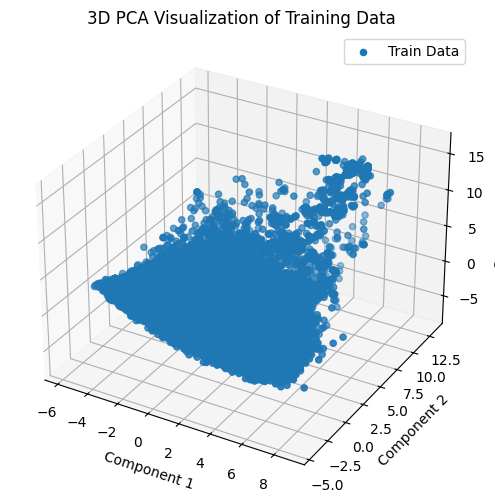

In [19]:
visualize_3d(X_train_pca, 'PCA')

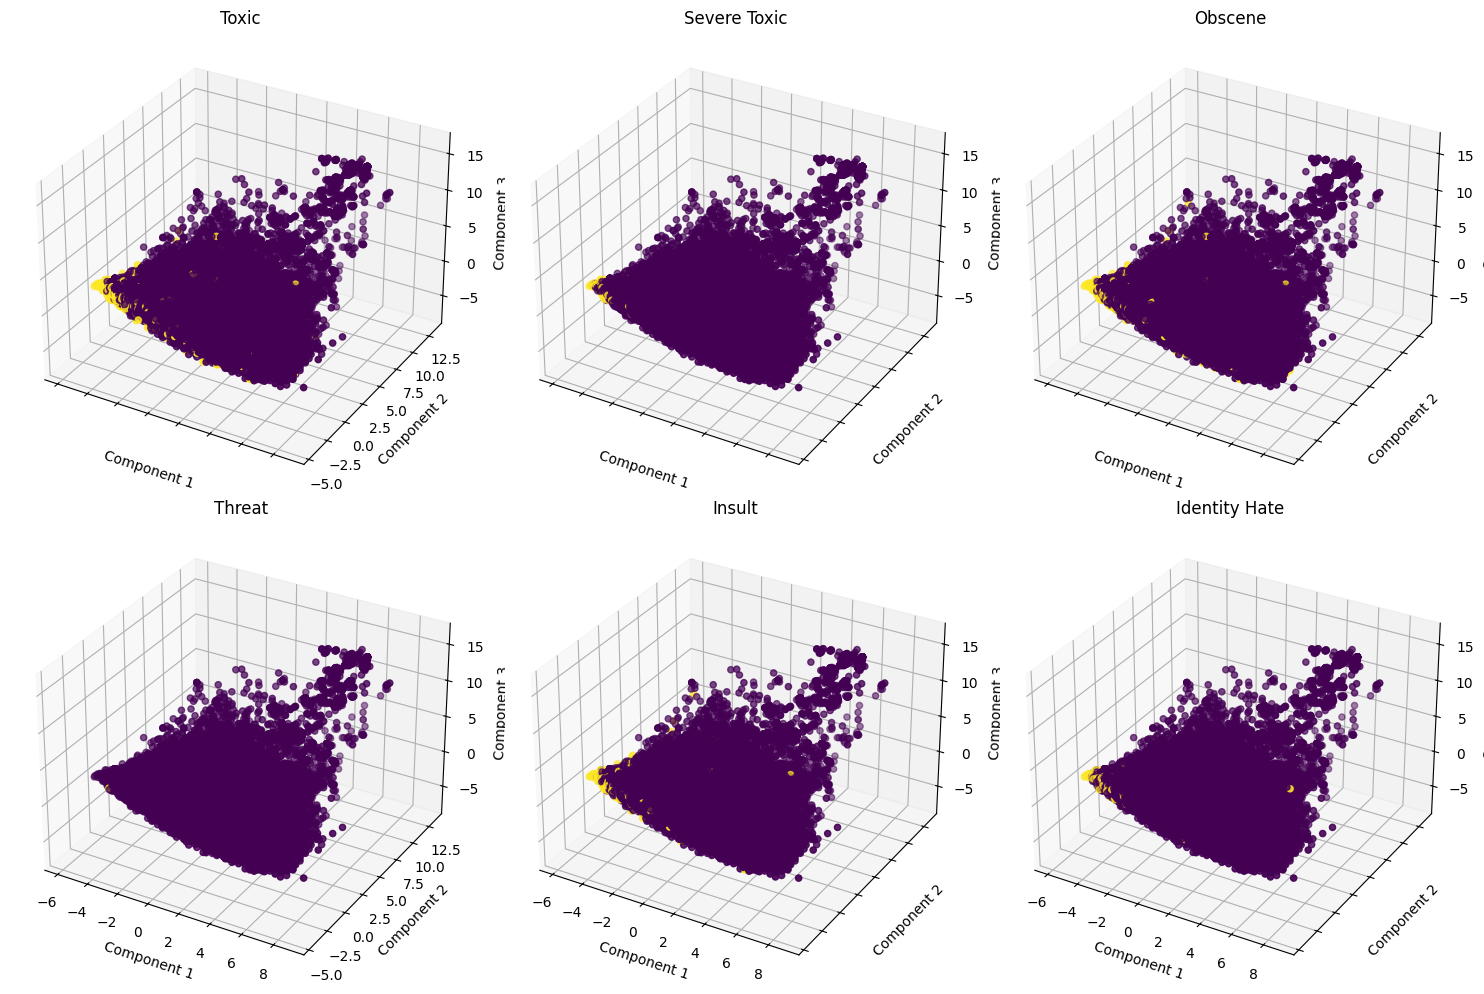

In [20]:
visualize_3d_labels(X_train_pca)

In [21]:
# Initializing PCA without specifying the number of components
pca = PCA()

# Fitting the PCA model to the training data
pca.fit(X_train_dense_scaled)

PCA()

Our next task is to learn how many components explain 80%, 90%, and 95% of total variance.

In [22]:
# run with max_features=500
# Specifying the desired explained variance ratios
desired_explained_variance_ratios = [0.8, 0.9, 0.95]

# Dictionary to store results
pca_results = {}

for desired_explained_variance_ratio in desired_explained_variance_ratios:
    # Determining the number of components needed for the desired explained variance
    n_components = (pca.explained_variance_ratio_.cumsum() >= desired_explained_variance_ratio).argmax() + 1
    print(f"Components to achieve explained variance of {desired_explained_variance_ratio}: {n_components}")

Components to achieve explained variance of 0.8: 365
Components to achieve explained variance of 0.9: 425
Components to achieve explained variance of 0.95: 458


# UMAP

In [23]:
# 11min to run with 1000 max_features, 7min with 500 max_features
# Initializing UMAP with the desired number of components
n_components_umap = 3

# Initializing UMAP model
umap_model = umap.UMAP(n_components=n_components_umap, n_epochs=100)

# Fitting and transforming the training data
X_train_umap = umap_model.fit_transform(X_train_dense)

# Printing the shape of the transformed data
print(f"X_train_umap shape: {X_train_umap.shape}")

X_train_umap shape: (159571, 3)


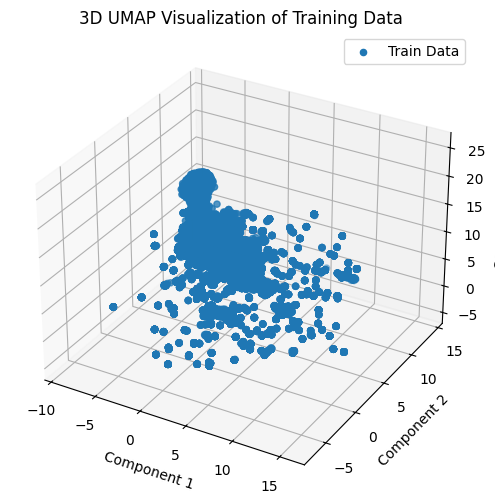

In [24]:
visualize_3d(X_train_umap, 'UMAP')

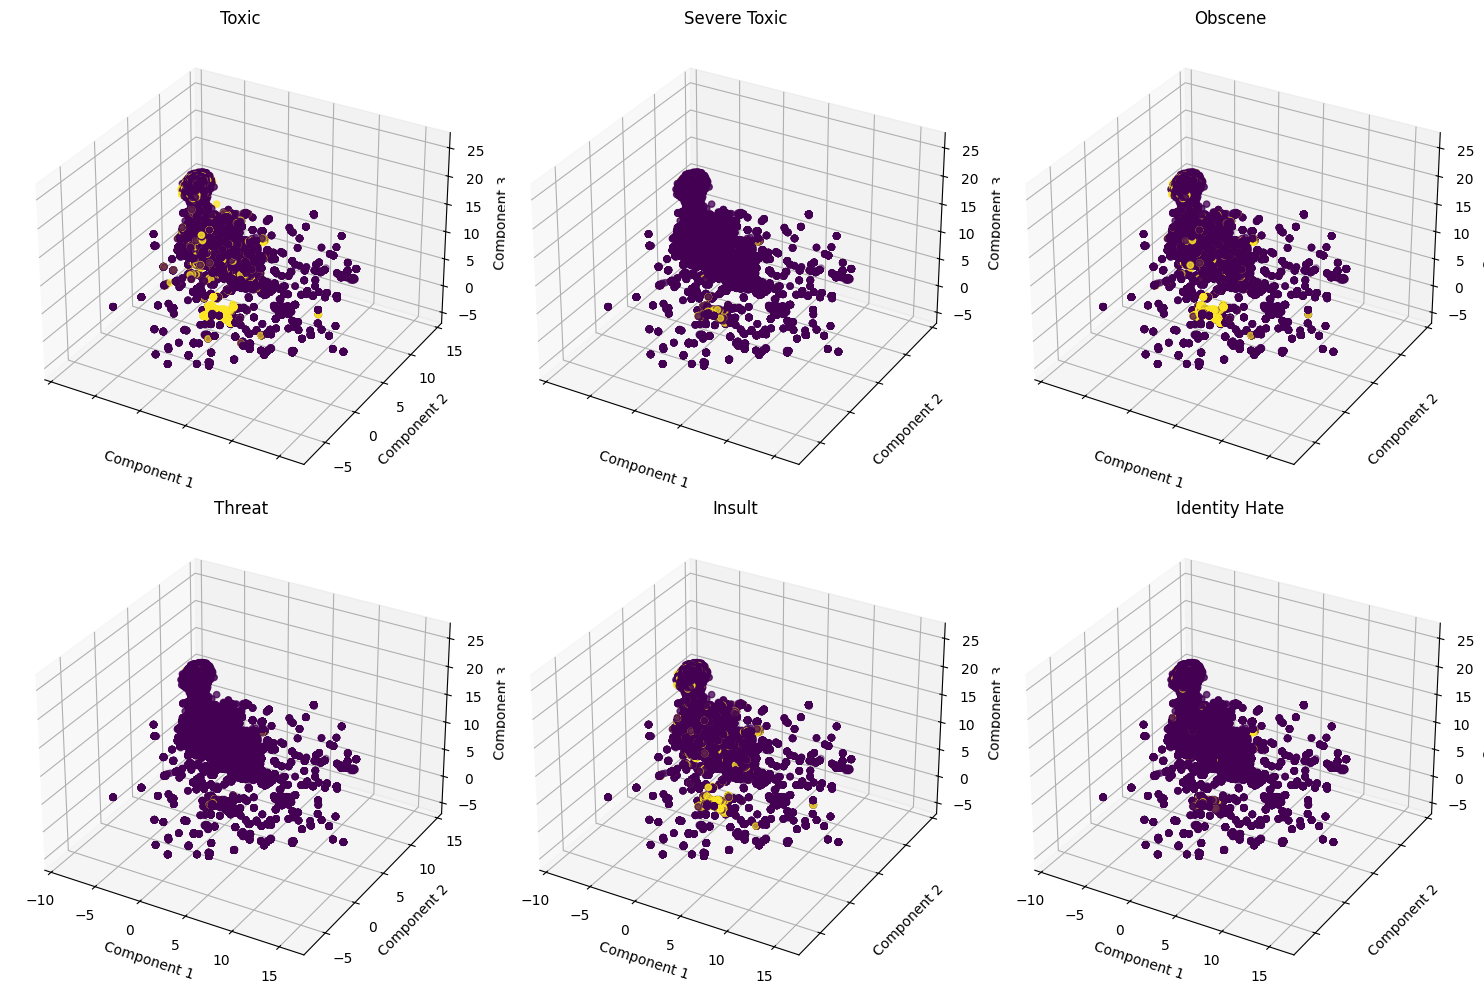

In [25]:
visualize_3d_labels(X_train_umap)

## Preprocessing

In [ ]:
# Setting the seed for reproducibility
np.random.seed(42)

# Randomly sampling 10,000 indices
sampled_indices = np.random.choice(X_train_dense.shape[0], 10000, replace=False)

# Using the sampled indices to get the corresponding subset from X_train_dense
X_train_dense_sampled = X_train_dense[sampled_indices]

# Checking the shape of the sampled subset
print(f"Shape of sampled subset: {X_train_dense_sampled.shape}")

Shape of sampled subset: (10000, 500)


In [ ]:
# 56sec
# Initializing UMAP with the desired number of components
n_components_umap = 3

# Initializing UMAP model
umap_model = umap.UMAP(n_components=n_components_umap)

# Fitting and transforming the training data
X_train_umap_sampled = umap_model.fit_transform(X_train_dense_sampled)

# Printing the shape of the transformed data
print(f"X_train_umap_sampled shape: {X_train_umap_sampled.shape}")

X_train_umap_sampled shape: (10000, 3)


In [ ]:
def visualize_clusters(X, n_clusters, clusters, algorithm):
  # Visualizing the clustered data in 3D
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot for each cluster
  for cluster_id in range(n_clusters):
      cluster_points = X[clusters == cluster_id]
      ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_id + 1}', marker='o')

  # Adding labels and title
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')
  ax.set_zlabel('Component 3')
  ax.set_title(f'{algorithm} Clustering of UMAP-transformed Sampled Data')
  ax.legend()

  # Showing the plot
  plt.show()

## K-Means

In [ ]:
# Performing KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X_train_umap_sampled)

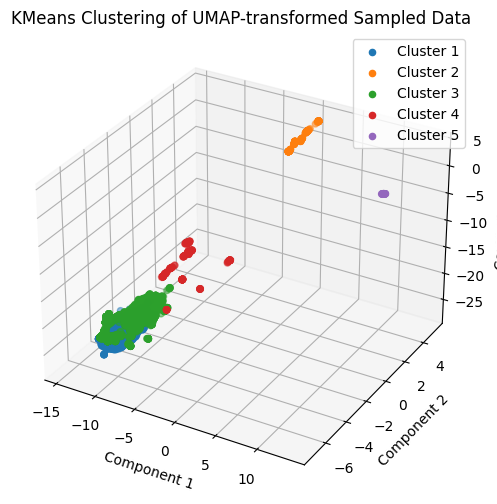

In [ ]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'KMeans')

Let's find the best number of clusters using Elbow Method.

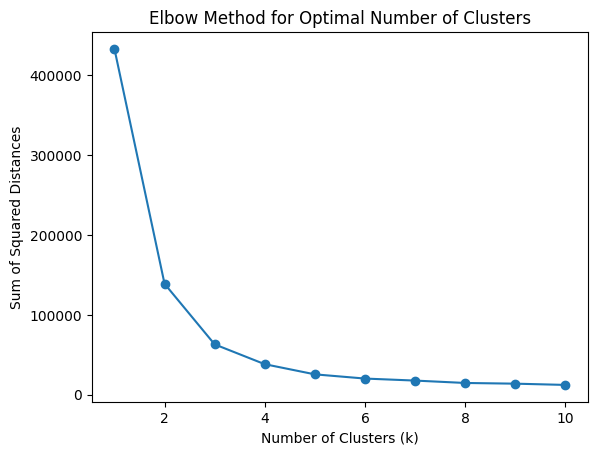

In [ ]:
# Specifying a range of cluster numbers
max_clusters = 10
sum_squared_distances = []

# Calculating sum of squared distances for different numbers of clusters
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_train_umap_sampled)
    sum_squared_distances.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, max_clusters + 1), sum_squared_distances, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

**4** looks like the optimal number of clusters.

In [ ]:
# Performing KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X_train_umap_sampled)

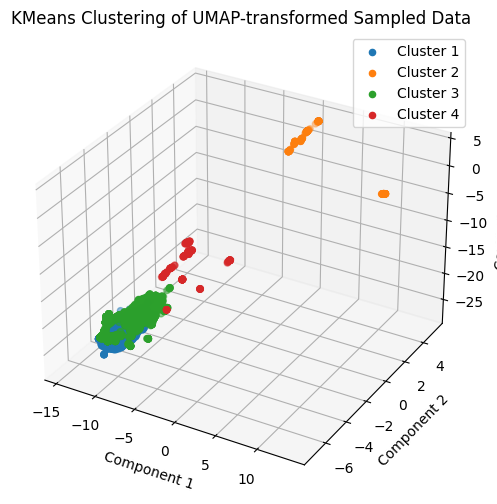

In [ ]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'KMeans')

## DBSCAN

In [ ]:
# Performing DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters = dbscan.fit_predict(X_train_umap_sampled)

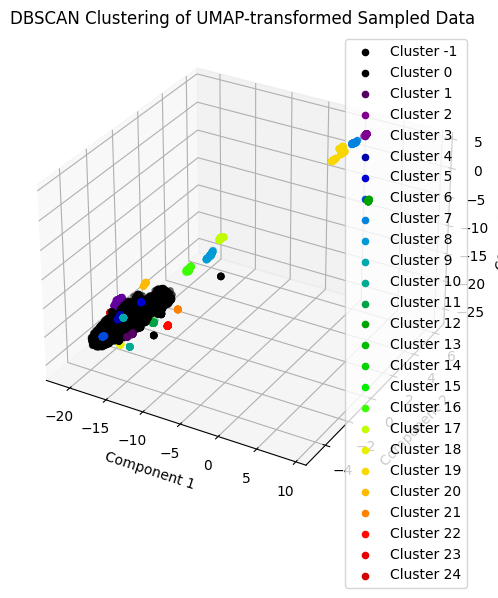

In [ ]:
# Visualizing the clustered data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
unique_clusters = np.unique(clusters)
for cluster_id in unique_clusters:
    if cluster_id == -1:
        # Outliers (noise points) are shown in black
        color = 'black'
    else:
        # Regular clusters are assigned different colors
        color = plt.cm.nipy_spectral(cluster_id / len(unique_clusters))

    cluster_points = X_train_umap_sampled[clusters == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_id}', color=color, marker='o')

# Adding labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('DBSCAN Clustering of UMAP-transformed Sampled Data')
ax.legend()

# Showing the plot
plt.show()

## Hierarchical Clustering

In [ ]:
# Performing Agglomerative Clustering
n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agg_clustering.fit_predict(X_train_umap_sampled)

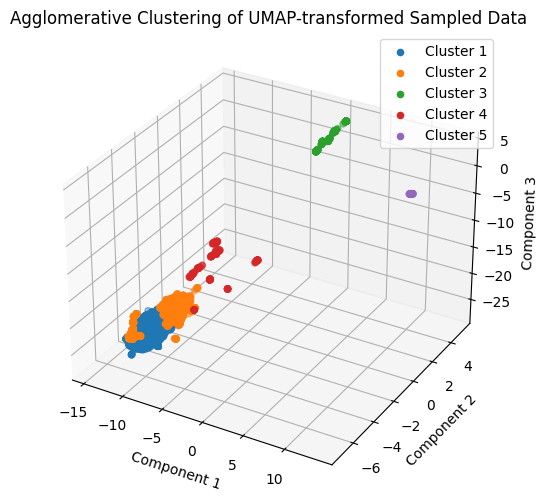

In [ ]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'Agglomerative')